# Using google's Lightweight MMM packag with channel/adstock tuning and exporting modelled response curves

This collab demostrates how you can use Lightweight MMM to easily tune your channel priors and adstock lag weights/decay in order to adjust media's contribution.

**Background**: the Lightweight MMM package is a great code base to easily create both national and geo hierarchical MMMs se: https://github.com/google/lightweight_mmm. However, using the default cost priors usually results in the media channels having very large contributions to the KPI. Further more, a standard practise is to limit adstock effects for very ephemeral channels like SEM.

In addition, it was noted that the response curves being plotted were using a "forward predict" method rather than simply utilising the transformed beta-hill response curve profiles. In marketing science, the practise and norm is to provide a diminishing curve profile that was fiited to the model (see https://github.com/google/lightweight_mmm/issues/51#issuecomment-1590601232)

In [ ]:
#!pip install --upgrade git+https://github.com/google/lightweight_mmm.git ### Uncomment this first and install. You;ll then need to comment it out and restart the Runtime (Ctrl+M)


# Import jax.numpy and any other library we might need.
import jax.numpy as jnp
import numpyro
import pandas as pd
import numpy as np


# Import the relevant modules of the library
from lightweight_mmm import lightweight_mmm
from lightweight_mmm import optimize_media
from lightweight_mmm import plot
from lightweight_mmm import preprocessing
from lightweight_mmm import utils

from sklearn.metrics import mean_absolute_percentage_error
from numpyro.infer import MCMC, NUTS, Predictive, SVI, Trace_ELBO, init_to_value


## Creating Synthetic Media and external factos

In [ ]:

SEED = 105
channel_names=['social','tv', 'sem', 'display', 'programmatic']



data_size = (52*3) + 26 # we'll be using 3 years of weekly data for trainingdata, and adding half a year as our test data
n_media_channels = len(channel_names)
n_extra_features = 5


In [ ]:
media_data, extra_features, target, costs = utils.simulate_dummy_data(
    data_size=data_size,
    n_media_channels=n_media_channels,
    n_extra_features=n_extra_features)

In [ ]:
# Split and scale data.
split_point = data_size - 26
# Media data
media_data_train = media_data[:split_point, ...]
media_data_test = media_data[split_point:, ...]
# Extra features
extra_features_train = extra_features[:split_point, ...]
extra_features_test = extra_features[split_point:, ...]
# Target
target_train = target[:split_point]

## Scaling of data

In [ ]:
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
extra_features_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)

media_data_train = media_scaler.fit_transform(media_data_train)
extra_features_train = extra_features_scaler.fit_transform(extra_features_train)
target_train = target_scaler.fit_transform(target_train)
costs = cost_scaler.fit_transform(costs)

## Tuning

Lightweight_mmm's default settings is to use the media channel's "spend/cost" as its prior when sampling from a half-normal distribution.

Any adstock effects using "lag_weight" assumes a beta distrbution with a concentration using these settings numpyro.distributions.Beta(concentration1=2., concentration0=1.)

In order to make parameter tuning for business use cases, I have suggested using a an array multiplier in order to a) adjust a media channel's effect on the KPI and b) reduce/limit adstock decay levels to levels which make business sense.

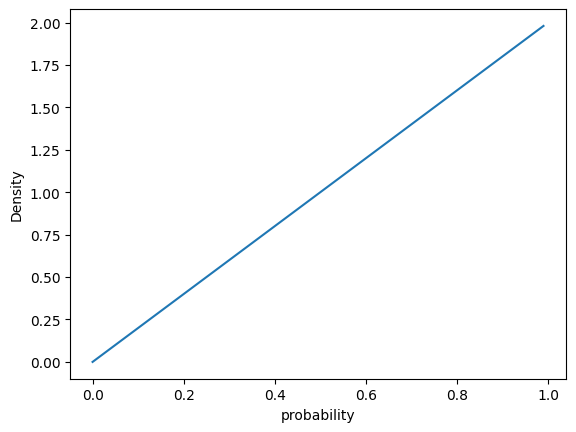

In [ ]:
## Example of the adstock's probability density

from numpyro import distributions as dist
import matplotlib.pyplot as plt
from jax.scipy.special import expit
from jax import lax, random

x = jnp.linspace(0, 1, 101)
plt.plot(x, jnp.exp(dist.Beta(concentration1=2, concentration0=1.).log_prob(x)))
plt.gca().set(xlabel="probability", ylabel="Density")
plt.show()



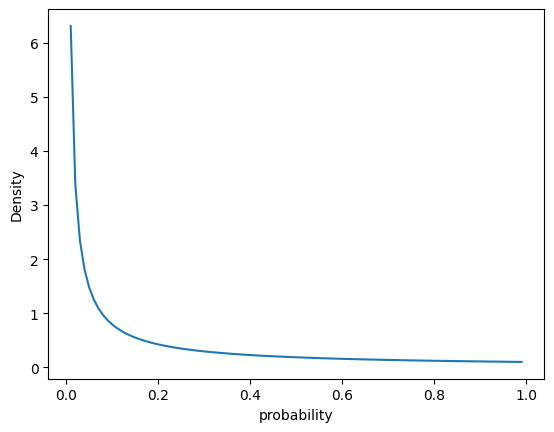

In [ ]:
## here is the probability when trying to reduce the adstock's effect to be near 0

x = jnp.linspace(0, 1, 101)
plt.plot(x, jnp.exp(dist.Beta(concentration1=0.1, concentration0=1).log_prob(x)))
plt.gca().set(xlabel="probability", ylabel="Density")
plt.show()

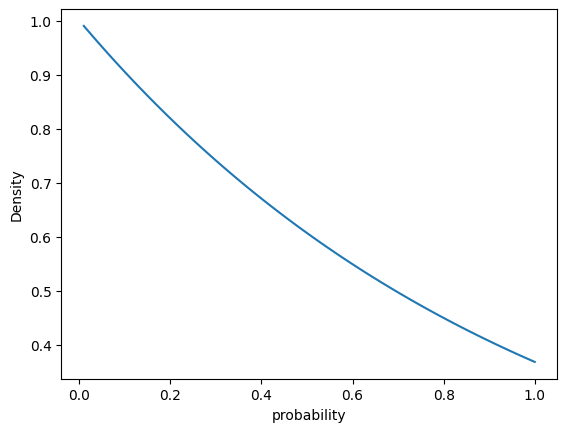

In [ ]:
x = jnp.linspace(0, 1, 101)
plt.plot(x, jnp.exp(dist.Gamma(concentration=1., rate=1.).log_prob(x)))
plt.gca().set(xlabel="probability", ylabel="Density")
plt.show()

## Diminishing Curve Tunning and How Lightweight uses mcmc sampling:

Looking at how we can utilise different prior sampling to affect the curve profile.

What we'll be doing is demonstrating how we can model a media channel's diminishing affect on some gausian noise

In [ ]:
def apply_exponent_safe(
    data: jnp.ndarray,
    exponent: jnp.ndarray
    ) -> jnp.ndarray:
  """Applies an exponent to given data in a gradient safe way.

  More info on the double jnp.where can be found:
  https://github.com/tensorflow/probability/blob/main/discussion/where-nan.pdf

  Args:
    data: Input data to use.
    exponent: Exponent required for the operations.

  Returns:
    The result of the exponent operation with the inputs provided.
  """
  exponent_safe = jnp.where(condition=(data == 0), x=1, y=data) ** exponent
  return jnp.where(condition=(data == 0), x=0, y=exponent_safe)



def hill(data: jnp.ndarray, half_max_effective_concentration: jnp.ndarray,
         slope: jnp.ndarray) -> jnp.ndarray:
  """Calculates the hill function for a given array of values.

  Refer to the following link for detailed information on this equation:
    https://en.wikipedia.org/wiki/Hill_equation_(biochemistry)

  Args:
    data: Input data.
    half_max_effective_concentration: ec50 value for the hill function.
    slope: Slope of the hill function.

  Returns:
    The hill values for the respective input data.
  """
  save_transform = apply_exponent_safe(
      data=data / half_max_effective_concentration, exponent=-slope)
  return jnp.where(save_transform == 0, x=0, y=1. / (1 + save_transform))


def adstock(data: jnp.ndarray,
            lag_weight: float = .9,
            normalise: bool = True) -> jnp.ndarray:
  """Calculates the adstock value of a given array.

  To learn more about advertising lag:
  https://en.wikipedia.org/wiki/Advertising_adstock

  Args:
    data: Input array.
    lag_weight: lag_weight effect of the adstock function. Default is 0.9.
    normalise: Whether to normalise the output value. This normalization will
      divide the output values by (1 / (1 - lag_weight)).

  Returns:
    The adstock output of the input array.
  """

  def adstock_internal(prev_adstock: jnp.ndarray,
                       data: jnp.ndarray,
                       lag_weight: float = lag_weight) -> jnp.ndarray:
    adstock_value = prev_adstock * lag_weight + data
    return adstock_value, adstock_value

  _, adstock_values = jax.lax.scan(
      f=adstock_internal, init=data[0, ...], xs=data[1:, ...])
  adstock_values = jnp.concatenate([jnp.array([data[0, ...]]), adstock_values])
  return jax.lax.cond(
      normalise,
      lambda adstock_values: adstock_values / (1. / (1 - lag_weight)),
      lambda adstock_values: adstock_values,
      operand=adstock_values)

Lets assume we only have one channel. We're assuming that media has a diminishing affect on sales and we're adding some noise to the mix

Text(0, 0.5, 'Channel Contribution')

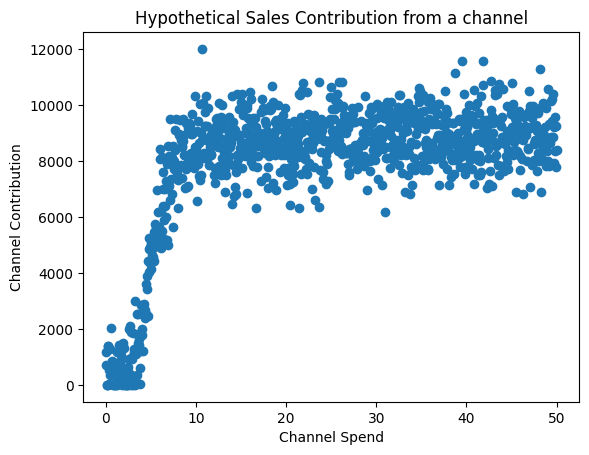

In [ ]:
##randomkey to generate new coefficient sampling
key=jax.random.PRNGKey(456)



test_media=jnp.linspace(0, 50, 1000)

cost=jnp.sum(test_media*0.15)

beta_media=numpyro.sample("beta_media", dist.HalfNormal(cost), rng_key=key)
half_eff=numpyro.sample("half_eff", dist.Gamma(concentration=1., rate=1.), rng_key=key)
lag=numpyro.sample("lag",dist.Beta(concentration1=1., concentration0=1.),rng_key=key)
slope_=numpyro.sample("slope", dist.Gamma(concentration=1., rate=1.), rng_key=key)

x=test_media
y=beta_media*hill(
    data=adstock(
        data=test_media.reshape(-1,1), lag_weight=lag, normalise=True),
    half_max_effective_concentration=half_eff,
    slope=slope_)

y_noise=(y+(np.random.normal(350, 900, len(x))).reshape(-1,1))+np.random.randint(0,6,len(x)).reshape(-1,1)
y_noise=y_noise.at[y_noise < 0].set(0)

plt.title("Hypothetical Sales Contribution from a channel")
plt.scatter(x,y_noise)
plt.xlabel("Channel Spend")
plt.ylabel("Channel Contribution")

Now we'll use Lightweight's hill model to see if we can fit a beta-hill dimishing curve to this generated data. Note: this synthetic data was made using a hill function for simplicity

In [ ]:


def hill_model(x,cost,y):
    beta_media=numpyro.sample("beta_media", dist.HalfNormal(cost))
    half_eff=numpyro.sample("half_eff", dist.Gamma(concentration=1., rate=1.))
    lag=numpyro.sample("lag",dist.Beta(concentration1=1., concentration0=1.))
    slope_=numpyro.sample("slope", dist.Gamma(concentration=1., rate=1.))


    y_pred=numpyro.deterministic('y_pred',beta_media*hill(
            data=adstock(
                data=x.reshape(-1,1), lag_weight=lag, normalise=True),
            half_max_effective_concentration=half_eff,
            slope=slope_))
    mu = numpyro.deterministic(name="mu", value=y_pred)

    with numpyro.plate(name="sigma_plate", size=1):
        sigma = numpyro.sample(
            name="sigma",
            fn=dist.Gamma(concentration=1., rate=1.))

    numpyro.sample(
      name="target", fn=dist.Normal(loc=mu, scale=sigma), obs=y)



In [ ]:
nuts_kernel = NUTS(hill_model, adapt_step_size=True)
mcmc = MCMC(nuts_kernel, num_chains=1, num_warmup=100, num_samples=100)
rng_key=random.PRNGKey(12)
mcmc.run(rng_key, x=x, cost=cost, y=y_noise)

sample: 100%|██████████| 200/200 [00:06<00:00, 31.09it/s, 11 steps of size 6.81e-04. acc. prob=0.95] 


MAPE: 0.0843353420495987


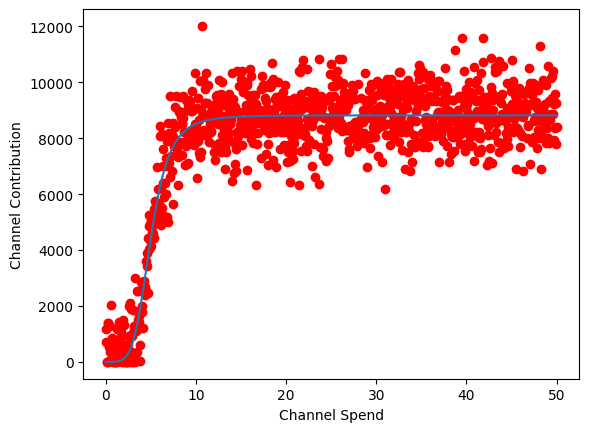

In [ ]:
y_pred=mcmc.get_samples()['mu'].mean(axis=0)
plt.scatter(x,y_noise, color='red',label="y_true")
plt.xlabel("Channel Spend")
plt.ylabel("Channel Contribution")
plt.plot(x,y_pred, label='y_pred')
print(f"MAPE: {mean_absolute_percentage_error(y,y_pred)}")

In [ ]:
mcmc.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
  beta_media   8862.38     30.53   8862.51   8813.17   8897.90     29.03      1.17
    half_eff      3.72      1.33      4.12      1.76      5.07      2.50      3.06
         lag      0.64      0.41      0.95      0.05      0.99      2.58      2.43
    sigma[0]    679.99     13.25    678.83    657.01    702.13     70.41      1.00
       slope      3.92      0.99      4.04      2.56      5.00      2.82      2.66

Number of divergences: 0


## Lets adjust the priors to demonstrate how we can adjust the shape of the curve

In [ ]:
## Note: we are using different concetrations
## In this case, we are reducing adstock as well as the diminishing point and slop of the curve


def hill_model2(x,cost,y):
    beta_media=numpyro.sample("beta_media", dist.HalfNormal(cost*0.1))
    half_eff=numpyro.sample("half_eff", dist.Gamma(concentration=0.1, rate=1.))
    lag=numpyro.sample("lag",dist.Beta(concentration1=0.1, concentration0=1.))
    slope_=numpyro.sample("slope", dist.Gamma(concentration=0.1, rate=1.))


    y_pred=numpyro.deterministic('y_pred',beta_media*hill(
            data=adstock(
                data=x.reshape(-1,1), lag_weight=lag, normalise=True),
            half_max_effective_concentration=half_eff,
            slope=slope_))
    mu = numpyro.deterministic(name="mu", value=y_pred)

    with numpyro.plate(name="sigma_plate", size=1):
        sigma = numpyro.sample(
            name="sigma",
            fn=dist.Gamma(concentration=1., rate=1.))

    numpyro.sample(
      name="target", fn=dist.Normal(loc=mu, scale=sigma), obs=y)

In [ ]:
nuts_kernel = NUTS(hill_model2, adapt_step_size=True)
mcmc2 = MCMC(nuts_kernel, num_chains=1, num_warmup=200, num_samples=200)
rng_key=random.PRNGKey(12)
mcmc2.run(rng_key, x=x, cost=cost, y=y_noise)

sample: 100%|██████████| 400/400 [00:05<00:00, 78.70it/s, 23 steps of size 2.40e-01. acc. prob=0.94] 


MAPE: 0.0843353420495987


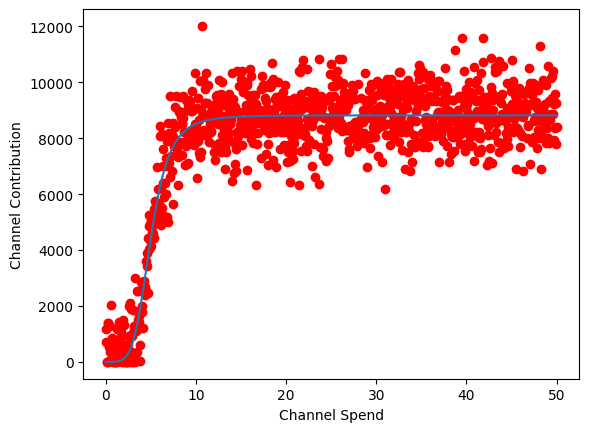

In [ ]:
y_pred2=mcmc2.get_samples()['mu'].mean(axis=0)
plt.scatter(x,y_noise, color='red',label="y_true")
plt.xlabel("Channel Spend")
plt.ylabel("Channel Contribution")
plt.plot(x,y_pred2.squeeze(), label='y_pred')
print(f"MAPE: {mean_absolute_percentage_error(y,y_pred2)}")


In [ ]:
mcmc2.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
  beta_media   8818.95     26.62   8820.45   8771.71   8857.93    151.94      1.00
    half_eff      4.99      0.05      4.99      4.90      5.06    246.85      1.00
         lag      0.03      0.09      0.00      0.00      0.08     51.51      1.02
    sigma[0]    680.14     10.58    679.66    665.81    701.09    224.30      1.00
       slope      4.79      0.19      4.79      4.48      5.11    231.44      1.00

Number of divergences: 0


## Scenario and assumptions:

Lets assume that from our prior knowledge that TV as a channel is less effective and that we posit that adstock decay rates for SEM is near 0.

Ee can make these adjustments by multiplying the TV's cost prior with a smaller multiplier in order to limit its effect.

In [ ]:
channel_contribution_weights={'social':1,
                 'tv':0.5,
                 'sem':1,
                 'display':1,
                 'programmatic':1}
mod_media_priors=jnp.array(list(channel_contribution_weights.values()))*costs


channel_adstock_weights={'social':2.,
                 'tv':2.,
                 'sem':0.01, ## It is commonly assumed that SEM has little to no adstock decay in the industry due to user browsing habits. The default beta is 2
                 'display':2.,
                 'programmatic':2.}
adstock_lag_weight_priors=jnp.array(list(channel_adstock_weights.values()))

#trailing setting custom concentration weights for half effective concentration
media_concentration_weights={'social':1,
                 'tv':0.8,
                 'sem':0.5,
                 'display':1,
                 'programmatic':1}

media_concentration_weights_priors=jnp.array(list(media_concentration_weights.values()))



In [ ]:
# See detailed explanation on custom priors in our documentation. https://lightweight-mmm.readthedocs.io/en/latest/custom_priors.html
#trailing setting custom concentration weights for half effective concentration
media_concentration_weights={'social':1,
                 'tv':0.8,
                 'sem':0.5,
                 'display':1,
                 'programmatic':1}

media_concentration_weights_priors=jnp.array(list(media_concentration_weights.values()))


channel_adstock_weights={'social':2.,
                 'tv':2.,
                 'sem':0.01, ## It is commonly assumed that SEM has little to no adstock decay in the industry due to user browsing habits. The default beta is 2
                 'display':2.,
                 'programmatic':2.}
adstock_lag_weight_priors=jnp.array(list(channel_adstock_weights.values()))


custom_priors = {
                 "lag_weight": numpyro.distributions.Beta(concentration1=adstock_lag_weight_priors, concentration0=jnp.ones(len(adstock_lag_weight_priors),)),
                 "half_max_effective_concentration": numpyro.distributions.Gamma(concentration=media_concentration_weights_priors, rate=jnp.ones(len(media_concentration_weights_priors),))
                 }

# Fit model.

mmm = lightweight_mmm.LightweightMMM(model_name="hill_adstock")
mmm.fit(media=media_data_train,
        extra_features=extra_features_train,
        media_prior=mod_media_priors,
        target=target_train,
        number_warmup=1000,
        number_samples=1000,
        number_chains=2,
        custom_priors=custom_priors)

/usr/local/lib/python3.10/dist-packages/lightweight_mmm/lightweight_mmm.py:358: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(
sample: 100%|██████████| 2000/2000 [02:00<00:00, 16.65it/s, 1023 steps of size 8.75e-04. acc. prob=0.89]


## Model performance checks

/usr/local/lib/python3.10/dist-packages/arviz/stats/stats_utils.py:509: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "stats_variance_1d" failed type inference due to: non-precise type pyobject
During: typing of argument at /usr/local/lib/python3.10/dist-packages/arviz/stats/stats_utils.py (511)

File "../usr/local/lib/python3.10/dist-packages/arviz/stats/stats_utils.py", line 511:
def stats_variance_1d(data, ddof=0):
    a_a, b_b = 0, 0
    ^

  @conditional_jit
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats_utils.py:509: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "stats_variance_1d" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "../usr/local/lib/python3.10/dist-packages/arviz/stats/stats_utils.py", line 512:
def stats_variance_1d(data, ddof=0):
    <source elided>
    a_a, b_b = 0, 0
    for i in d

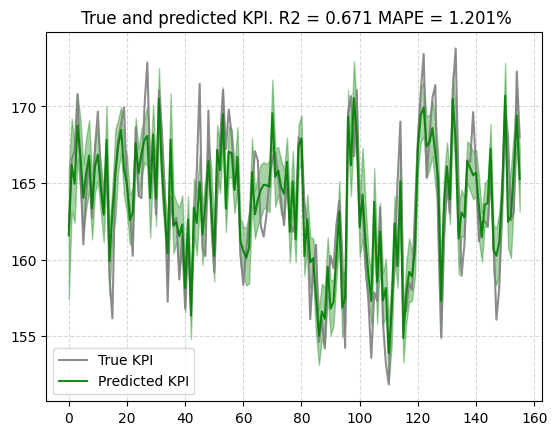

In [ ]:

plot.plot_model_fit(mmm, target_scaler=target_scaler)

In [ ]:


media_contribution, roi_hat = mmm.get_posterior_metrics(target_scaler=target_scaler, cost_scaler=cost_scaler)

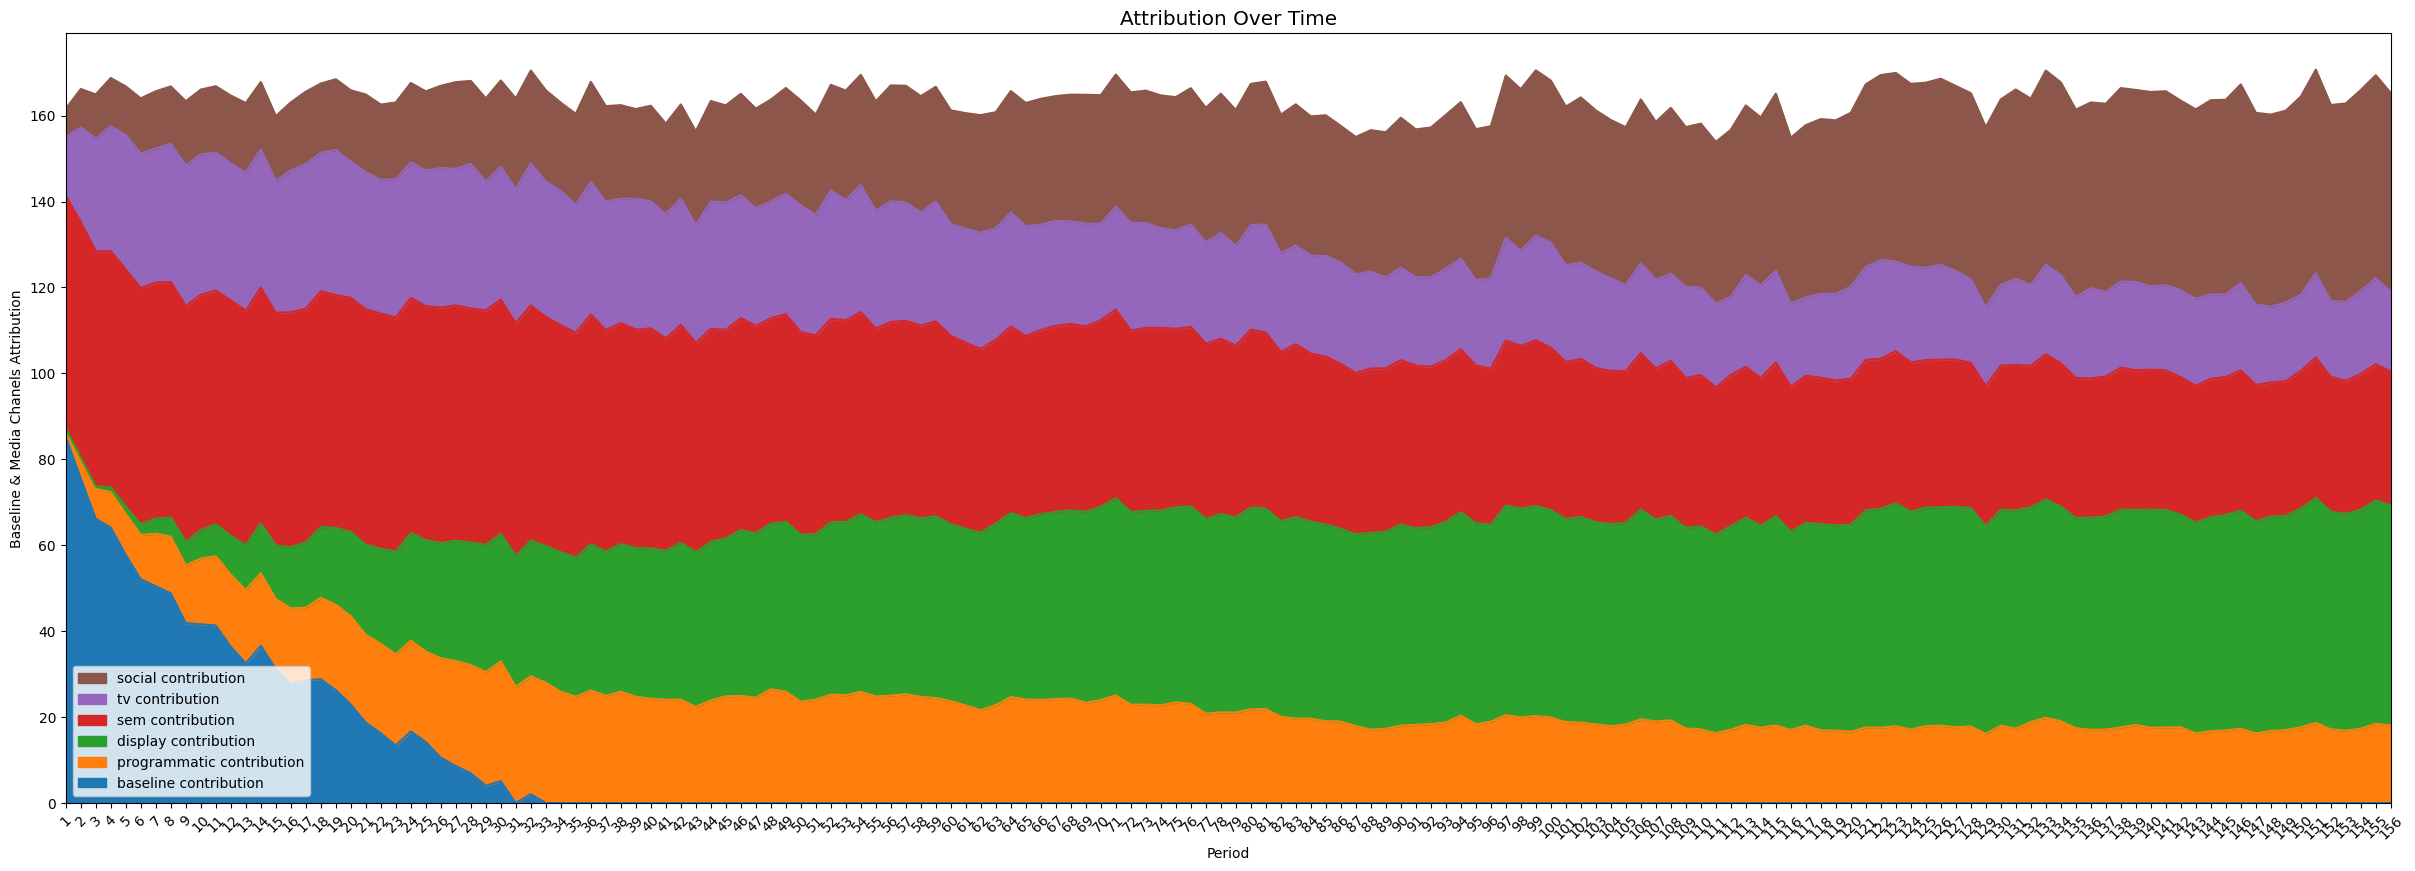

In [ ]:

plot.plot_media_baseline_contribution_area_plot(media_mix_model=mmm,
                                              target_scaler=target_scaler,
                                                channel_names=channel_names,
                                                fig_size=(30,10))

Here we can see the adstock effect for SEM being adjusted to near zero

In [ ]:
pd.DataFrame({'channels':channel_names, 'adstock_decay':mmm.trace['lag_weight'].mean(axis=0)})

,channels,adstock_decay
0,social,0.810727
1,tv,0.565595
2,sem,0.019001
3,display,0.967874
4,programmatic,0.803808


## Custom Hill_Adstock Dataframe from plotting

Here we see an example of using the transform hill adstock's



In [ ]:
from lightweight_mmm import media_transforms
from lightweight_mmm.plot import _calculate_number_rows_plot
import seaborn as sns
_PALETTE = sns.color_palette(n_colors=100)

def media_transform_hill_adstock(media_mix_model,
                                  media_data,
                           lag_weight,
                           half_max_effective_concentration,
                           slope, apply_adstock, normalise):
  """Transforms the input data with the adstock and hill functions.

  Args:
  media_data: Media data to be transformed. It is expected to have 2 dims for
    national models and 3 for geo models.
  normalise: Whether to normalise the output values.

  Returns:
  The transformed media data.
  """
  if media_mix_model.n_geos > 1:
      lag_weight=jnp.repeat(lag_weight,media_mix_model.n_geos).reshape(half_max_effective_concentration.shape)
      slope = jnp.squeeze(jnp.repeat(slope,media_mix_model.n_geos).reshape(half_max_effective_concentration.shape))


  if apply_adstock:
    return media_transforms.hill(
    data=media_transforms.adstock(
        data=media_data, lag_weight=lag_weight, normalise=normalise),
    half_max_effective_concentration=half_max_effective_concentration,
    slope=slope)

  else:
    return media_transforms.hill(
    data=media_data,
    half_max_effective_concentration=half_max_effective_concentration,
    slope=slope)


In [ ]:
def plot_and_df_response_curves(
    percentage_add=2,
    media_mix_model=mmm,
    steps=25,
    costs=costs,
    figure_size=(6,9),
    n_columns=3,
    apply_log_scale=False,
    legend_fontsize = 8,
    media_scaler=media_scaler,
    target_scaler=target_scaler,
    cost_scaler=cost_scaler
  ):
  media=media_mix_model.media

  if cost_scaler:
    costs=cost_scaler.inverse_transform(costs)

  prices=costs/media_data.sum(axis=0)
  media = media_mix_model.media
  media_maxes = media.max(axis=0) * (1 + percentage_add)
  half_max_effective_concentration=media_mix_model._mcmc.get_samples()['half_max_effective_concentration'].mean(axis=0)
  lag_weight=media_mix_model._mcmc.get_samples()['lag_weight'].mean(axis=0)
  slope=media_mix_model._mcmc.get_samples()['slope'].mean(axis=0)
  beta_media=media_mix_model.trace['coef_media'].mean(axis=0)

  media_ranges =jnp.linspace(start=0, stop=media_maxes, num=steps)

  if media_scaler:
    media_ranges=media_scaler.inverse_transform(media_ranges)

  spend_range=media_ranges*prices




  media_response=beta_media*media_transform_hill_adstock(media_mix_model,
                                    media_ranges,
                            lag_weight,
                            half_max_effective_concentration=half_max_effective_concentration,
                                                        apply_adstock=True,
                            slope=slope, normalise=True)

  if target_scaler:
    media_response = target_scaler.inverse_transform(media_response)



  df=pd.DataFrame(index=[i for i in range(len(media_ranges))])

  for j,k in enumerate(channel_names):
      x=spend_range[:,j]
      z=media_ranges[:,j]
      y=media_response[:,j]

      df[f'{k}_contribution']=y
      df[f'{k}_spend']=x


  fig = plt.figure(media_mix_model.n_media_channels + 1,
                    figsize=figure_size,
                    tight_layout=True)
  n_rows = _calculate_number_rows_plot(
      n_media_channels=media_mix_model.n_media_channels, n_columns=n_columns)
  last_ax = fig.add_subplot(n_rows, 1, n_rows)

  for i in range(media_mix_model.n_media_channels):
    ax = fig.add_subplot(n_rows, n_columns, i + 1)
    sns.lineplot(
        x=spend_range[:, i],
        y=media_response[:, i],
        label=media_mix_model.media_names[i],
        color=_PALETTE[i],
        ax=ax)
    sns.lineplot(
        x=spend_range[:, i],
        y=jnp.log(media_response[:, i]) if apply_log_scale else media_response[:, i],
        label=media_mix_model.media_names[i],
        color=_PALETTE[i],
        ax=last_ax)
    kpi_label='KPI'
    ax.set_ylabel(kpi_label)
    ax.set_xlabel("Normalized Spend" if not media_scaler else "Spend")
    ax.legend(fontsize=legend_fontsize)

  fig.suptitle("Response curves", fontsize=20)
  last_ax.set_ylabel(kpi_label if not apply_log_scale else f"log({kpi_label})")
  last_ax.set_xlabel("Normalized spend per channel"
                    if not media_scaler else "Spend per channel")
  plt.close()

  return df,fig

In [ ]:
rc_df, rc_plot=plot_and_df_response_curves(
    percentage_add=2,
    media_mix_model=mmm,
    steps=25,
    costs=costs,
    figure_size=(6,9),
    n_columns=3,
    apply_log_scale=False,
    legend_fontsize = 8,
    media_scaler=media_scaler,
    target_scaler=target_scaler,
    cost_scaler=cost_scaler
    )

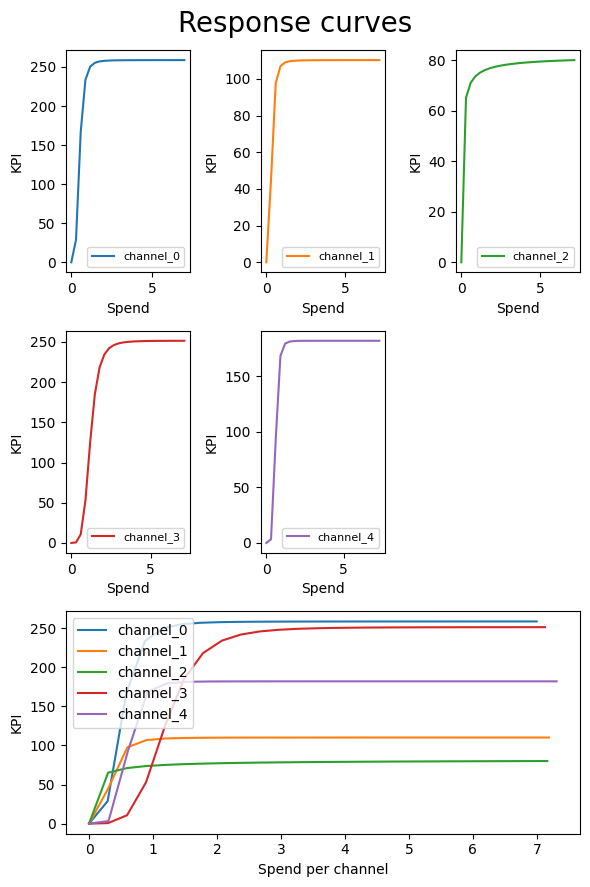

In [ ]:
rc_plot